**Resources:**
- [Article](https://www.linkedin.com/pulse/bert-multi-class-text-classification-your-dataset-kumar-deepak?articleId=6599156459685154816)
- [GitHub](https://github.com/kumardeepak/bert-multi-class) (that contains the notebook)

# Loading the libraries

In [1]:
!pip install transformers

     |████████████████████████████████| 757kB 10.1MB/s 
     |████████████████████████████████| 3.0MB 50.0MB/s 
     |████████████████████████████████| 1.1MB 43.9MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1c4a1279eb593b72b2f6ef361ab4dd0a5fc584f9bb9bc5dbb84ed0ae3b5b7775
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
# loading drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Note:** I changed the `WarmupLinearSchedule` to `get_linear_schedule_with_warmup` using this [helpful issue](https://github.com/huggingface/transformers/issues/2082) as a reference.

In [3]:
import pandas as pd
import uuid
import os
import random
from argparse import Namespace

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.utils.data.distributed import DistributedSampler

from tqdm import tqdm, trange

from transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer)
from transformers import AdamW, get_linear_schedule_with_warmup

MODEL_CLASSES = { 'bert': (BertConfig, BertForSequenceClassification, BertTokenizer) }

#import warnings
#warnings.filterwarnings("ignore")

import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

# Data Playground

## Slice the data into two

In [4]:
import numpy as np
data = pd.read_csv('/content/drive/My Drive/Team 4/WorkOnMergedData/final_merged_data.csv')
data['Leading Comment'] = data['Leading Comment'].apply(lambda x: str(x))
data['Category'] = data['Category'].apply(lambda x: str(x))
df = data[['Leading Comment', 'Category']] 
df.head()

,Leading Comment,Category
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


In [5]:
df.rename(columns={'Leading Comment': 'texts', 'Category': 'labels'}, inplace=True)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,texts,labels
0,Yesterday I lowered the price of an item to ma...,Fulfillment By Amazon
1,I got my new credit card and before I could up...,Fulfillment By Amazon
2,I sent an FBA shipment on November 26. They sh...,Fulfillment By Amazon
3,"Hi, I need to know the products stock in Selle...",Fulfillment By Amazon
4,Just here to vent at the Asia based Seller Sup...,Fulfillment By Amazon


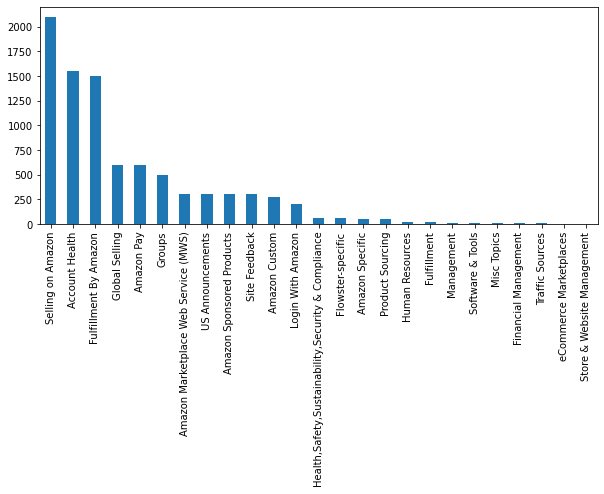

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,4))
df.labels.value_counts().plot(kind='bar');

In [206]:
df.labels.unique()

array(['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management'],
      dtype=object)

In [207]:
df.labels.unique().shape

(25,)

In [7]:
categories = ['Fulfillment By Amazon', 'Amazon Sponsored Products',
       'Account Health', 'Selling on Amazon', 'Global Selling', 'Groups',
       'Health,Safety,Sustainability,Security & Compliance',
       'Amazon Marketplace Web Service (MWS)', 'Login With Amazon',
       'Amazon Pay', 'Amazon Custom', 'US Announcements', 'Site Feedback',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']

In [8]:
# categories with less data
categ_wld = ['Health,Safety,Sustainability,Security & Compliance',
       'Financial Management', 'Product Sourcing', 'Human Resources',
       'Amazon Specific', 'Flowster-specific', 'Software & Tools',
       'Fulfillment', 'Traffic Sources', 'Management', 'Misc Topics',
       'eCommerce Marketplaces', 'Store & Website Management']
len(categ_wld)

13

In [9]:
# dataframe with only the categories containing less data
data_wlc = df[df['labels'].isin(categ_wld)]

In [10]:
plt.figure(figsize=(10,4))
data_wlc.labels.value_counts().plot(kind='bar');

NameError: ignored

In [11]:
categ_wed = []
for categ in categories:
  if categ not in categ_wld:
    # category with enough data
    categ_wed.append(categ)

In [12]:
len(categ_wed)

12

In [13]:
# dataframe with only the categories containing enough data
data_wec = df[df['labels'].isin(categ_wed)]

In [14]:
plt.figure(figsize=(10,4))
data_wec.labels.value_counts().plot(kind='bar');

NameError: ignored

In [216]:
data_wec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8516 entries, 0 to 8578
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   8516 non-null   object
 1   labels  8516 non-null   object
dtypes: object(2)
memory usage: 199.6+ KB


## Augment the data

In [217]:
!pip install git+https://github.com/makcedward/nlpaug.git numpy matplotlib python-dotenv

  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-2wswgfxt
  Running command git clone -q https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-2wswgfxt
  Created wheel for nlpaug: filename=nlpaug-0.0.14-cp36-none-any.whl size=583433 sha256=d35cc5b568a1df1b3c62402fc229167f8051eeafea4bb8238d264c9b3591faa3
  Stored in directory: /tmp/pip-ephem-wheel-cache-uffwdga_/wheels/2b/ef/30/a4e22f9a97373c9ab6763670c94aa5e111b0b956983f3892a4
Successfully built nlpaug


In [218]:
cd /content/drive/My Drive/Team 4/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [219]:
!git clone https://github.com/makcedward/nlpaug.git

fatal: destination path 'nlpaug' already exists and is not an empty directory.


In [220]:
cd nlpaug

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData/nlpaug


In [221]:
import os
os.environ["MODEL_DIR"] = '../model'

In [222]:
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

In [223]:
# augmenting with BERT
texts = data_wlc['texts']
augmented_text_bert = []
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")
for text in texts:
  augmented_text_bert.append(aug.augment(text))

In [224]:
# augmenting with DistillBERT
texts = data_wlc['texts']
augmented_text_distilbert = []
aug = naw.ContextualWordEmbsAug(
    model_path='distilbert-base-uncased', action="substitute")
for text in texts:
  augmented_text_distilbert.append(aug.augment(text))

In [225]:
# bert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_bert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
amazon is asking me to provide them with a registration of my product . i did submit them a registration but they claim it ’ s not a correct one . i buy the ingredient of the capsules from a shop , then i sell , or sell . i have know clue on how to register on the fda website because they only allowed us to register a food label . please stop me ! ! !


In [226]:
# distillbert-base-uncased
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_distilbert[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
oracle is advising me to provide them for a registration of my product . i did submit them a registration but they said it ’ s not the correct one . i buy every ingredient of the capsules from a manuafacturer , then i repackaged ingredients and sell . consumers barely know clue on how to register on the fda website because amazon only allowed me to register a food facility . and help yourself ! ! !


In [227]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [228]:
# Substitute word by WordNet's synonym
augmented_text_wordnet = []
aug = naw.SynonymAug(aug_src='wordnet')
for text in texts:
  augmented_text_wordnet.append(aug.augment(text))

print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_wordnet[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
Amazon is inquire me to provide them with a registration of my product . One did submit them a registration only they say it ’ s not the correct one . I buy the ingredient of the capsules from a manuafacturer , then I repackaged them and sell . I have know clue on how to register on the FDA site because they only allowed me to register a food facility . Please help me ! ! !


In [229]:
# Substitute word by GPT2's synonym
aug = nas.ContextualWordEmbsForSentenceAug(model_path='gpt2')
augmented_text_gpt2 = []
for text in texts:
  augmented_text_gpt2.append(aug.augment(text))

print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text_gpt2)

Original:
Have questions about Store & Website Management? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.
Augmented Text:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!! <|endoftext|> N ash ville Mayor Doug Kle ff eb ack released a public statement to the press during the first presidential deb ates.', 'Account infringement is complained, I submitted multiple action plans to the Amazon team, but it didn’t work. Later, Amazon offers a complainant’s information I tried to contact the other party, but they did not reply to me. I hired a lawyer to contact them, and they did not respond, My shop was closed for more 

In [230]:
# Substitute word by Roberta's synonym
aug = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")
augmented_text_roberta = []
for text in texts:
  augmented_text_roberta.append(aug.augment(text))

print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text_roberta)

Original:
Have questions about Store & Website Management? This is the category to use. Please be sure to select the most appropriate sub-category for your questions.
Augmented Text:
[' Amazon stopped asking me to provide them with a copy of my product . I did submit them for registration and they said it � � s not the correct one . I get the ingredient of the capsules from a man u af act urer , then have rep ack aged them and sell . They have know clue on how to file on the FDA website but they only allowed me a register a food facility . Please help me !!!', ' After infringement is complained , I sent multiple service plans to the Amazon team , and it didn � � t work . Later , Amazon offers a complainant � � s information I tried to contact the other party , but they did not reply to me . I hired my lawyer to contact them , and they did not respond , My shop is closed for more than 40 days and I received a subpoena from the court . They want to consult everyone , but the other party 

In [231]:
import sklearn.datasets
import re

import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw

def _tokenizer(text, token_pattern=r"(?u)\b\w\w+\b"):
    token_pattern = re.compile(token_pattern)
    return token_pattern.findall(text)

# Load sample data
train_data = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
train_x = train_data.data

# Tokenize input
train_x_tokens = [_tokenizer(x) for x in train_x]

# Train TF-IDF model
tfidf_model = nmw.TfIdf()
tfidf_model.train(train_x_tokens)
tfidf_model.save('.')

# Load TF-IDF augmenter
aug = naw.TfIdfAug(model_path='.', tokenizer=_tokenizer)

texts = data_wlc['texts']

augmented_text_tfidf = []
for text in texts:
  augmented_text_tfidf.append(aug.augment(text))

In [232]:
print("Original:")
print(texts[0:1].values)
print("Augmented Text:")
print(augmented_text_tfidf[0])

Original:
['Amazon is asking me to provide them with a registration of my product. I did submit them a registration but they said it’s not the correct one. I buy the ingredient of the capsules from a manuafacturer, then I repackaged them and sell. I have know clue on how to register on the FDA website because they only allowed me to register a food facility. Please help me!!!']
Augmented Text:
Amazon is asking me BMPGR provide them with 100M listname my product did submit them registration but they said it not the correct one buy the ingredient of the capsules from manuafacturer then repackaged 11100101 W6NO Admin have Omega ings fumble how to register on the FOB website because they only allowed me to register food facility Please help me


In [233]:
# augmenting with bert
aug_data = pd.DataFrame({'texts':augmented_text_bert,
                         'labels': data_wlc['labels']})
aug_data.head()

,texts,labels
4202,amazon is asking me to provide them with a reg...,"Health,Safety,Sustainability,Security & Compli..."
4203,"account infringement is complained , i submitt...","Health,Safety,Sustainability,Security & Compli..."
4204,hi … amazon released about 17 of my listings a...,"Health,Safety,Sustainability,Security & Compli..."
4205,"hello there , amazon suspended my account beca...","Health,Safety,Sustainability,Security & Compli..."
4206,"hello , you asked me why i installed suspected...","Health,Safety,Sustainability,Security & Compli..."


In [234]:
# augmenting with distillbert
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_distilbert,
                         'labels': data_wlc['labels']}))
aug_data.head()

,texts,labels
4202,amazon is asking me to provide them with a reg...,"Health,Safety,Sustainability,Security & Compli..."
4203,"account infringement is complained , i submitt...","Health,Safety,Sustainability,Security & Compli..."
4204,hi … amazon released about 17 of my listings a...,"Health,Safety,Sustainability,Security & Compli..."
4205,"hello there , amazon suspended my account beca...","Health,Safety,Sustainability,Security & Compli..."
4206,"hello , you asked me why i installed suspected...","Health,Safety,Sustainability,Security & Compli..."


In [235]:
# augmenting with gpt2
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_gpt2,
                              'labels': data_wlc['labels']}))

In [236]:
# augmenting with roberta
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_roberta,
                              'labels': data_wlc['labels']}))

In [237]:
# augmenting with tf-idf
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_tfidf,
                              'labels': data_wlc['labels']}))

In [238]:
# augmenting with wordnet
aug_data = aug_data.append(pd.DataFrame({'texts':augmented_text_wordnet,
                              'labels': data_wlc['labels']}))

In [239]:
aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1950 non-null   object
 1   labels  1950 non-null   object
dtypes: object(2)
memory usage: 45.7+ KB


In [240]:
aug_data_wlc = data_wlc.copy()

In [241]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   325 non-null    object
 1   labels  325 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


In [242]:
aug_data_wlc = aug_data_wlc.append(aug_data)

In [243]:
aug_data_wlc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2275 entries, 4202 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   2275 non-null   object
 1   labels  2275 non-null   object
dtypes: object(2)
memory usage: 53.3+ KB


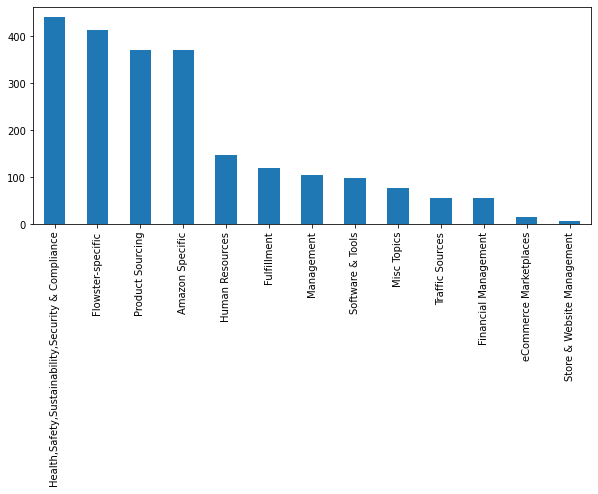

In [244]:
plt.figure(figsize=(10,4))
aug_data_wlc.labels.value_counts().plot(kind='bar');

In [245]:
full_aug_data = data_wec.append(aug_data_wlc)

In [246]:
full_aug_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10791 entries, 0 to 8840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   10791 non-null  object
 1   labels  10791 non-null  object
dtypes: object(2)
memory usage: 252.9+ KB


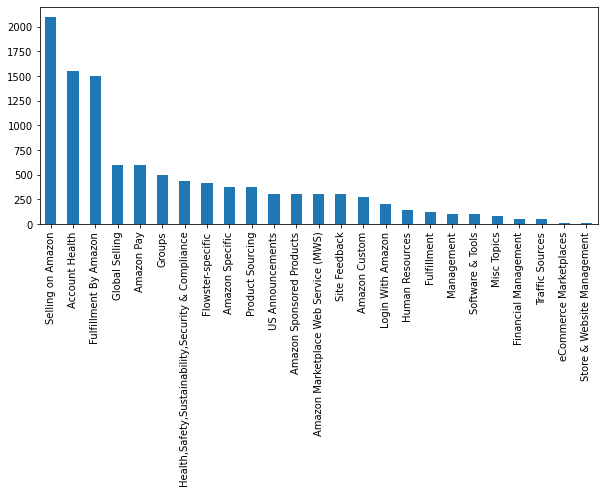

In [247]:
plt.figure(figsize=(10,4))
full_aug_data.labels.value_counts().plot(kind='bar');

In [248]:
cd /content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData

/content/drive/.shortcut-targets-by-id/1PXqnOQuOVInoF3I67K_93-Qpq7PKhVCX/WorkOnMergedData


In [249]:
full_aug_data.to_csv('full_aug_data.csv')

# Playing around with the data (slicing - augmenting)
**STEP 1: Slicing the data**  
We will work with the dataframe which categories has data with a minimum of 250 examples.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by `dropping the categories` that had less data.  
The performance improved only by a 0.01.
Perhaps that isn't the problem.  

**STEP 2: Augmenting the data**  
The data has been augmented 5 times by different strategies.  
**Goal:** Determine if the number of examples in a category affects the performance of the model by`augmenting the data of categories` that had less data.

In [250]:
# The above tests where performed on : split the data into 60%, 20%, 20%
#train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [251]:
# split the data into 80%, 10%, 10%
#train, validate, test = np.split(data_wec.sample(frac=1), [int(.8*len(data_wec)), int(.9*len(data_wec))])

In [252]:
full_aug_data['texts'] = full_aug_data['texts'].apply(lambda x: str(x))
full_aug_data['labels'] = full_aug_data['labels'] .apply(lambda x: str(x))

In [277]:
for text in full_aug_data['labels']:
  if type(text) is  not str:
    print(text)

In [278]:
for text in full_aug_data['texts']:
  if type(text) is  not str:
    print(text)

In [279]:
text = 'Amazon is asking me BMPGR provide them with 100M listname my product did submit them registration but they said it not the correct one buy the ingredient of the capsules from manuafacturer then repackaged 11100101 W6NO Admin have Omega ings fumble how to register on the FOB website because they only allowed me to register food facility Please help me'
for word in text:
  if type(word) is not str:
    print(word) 

In [309]:
if not isinstance(text, str):
  print(text)

In [282]:
full_aug_data.isna().sum()

texts     0
labels    0
dtype: int64

In [284]:
full_aug_data.dropna(axis='columns', inplace=True)

In [291]:
# split the data into 80%, 10%, 10%
train, validate, test = np.split(full_aug_data.sample(frac=1), [int(.8*len(full_aug_data)), int(.9*len(full_aug_data))])

In [292]:
train.isna().sum()

texts     0
labels    0
dtype: int64

In [308]:
if test['texts'].str.contains('NaN', regex=True).any():
  print(yes)

In [298]:
def stringify(df):
  df['texts'] = df['texts'].apply(lambda x: str(x))
  df['labels'] = df['labels'] .apply(lambda x: str(x))

In [300]:
stringify(train)
stringify(validate)
stringify(test)

In [312]:
for text in full_aug_data['texts']:
  if not isinstance(text, str):
    print(text)

In [313]:
for text in full_aug_data['labels']:
  if not isinstance(text, str):
    print(text)

In [293]:
validate.isna().sum()

texts     0
labels    0
dtype: int64

In [294]:
test.isna().sum()

texts     0
labels    0
dtype: int64

In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8632 entries, 5591 to 6496
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   8632 non-null   object
 1   labels  8632 non-null   object
dtypes: object(2)
memory usage: 202.3+ KB


In [255]:
validate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079 entries, 6374 to 3459
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1079 non-null   object
 1   labels  1079 non-null   object
dtypes: object(2)
memory usage: 25.3+ KB


In [256]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1080 entries, 298 to 386
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   1080 non-null   object
 1   labels  1080 non-null   object
dtypes: object(2)
memory usage: 25.3+ KB


In [257]:
train.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/train.csv")
validate.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/val.csv")
test.to_csv("/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented/test.csv")

In [258]:
args = Namespace(
    n_gpu=1,
    seed=1337,
    train_batch_size=8,
    per_gpu_train_batch_size=8,
    per_gpu_eval_batch_size=8,
    local_rank=-1,
    max_seq_length= 512,#256, #128
    gradient_accumulation_steps=1,
    learning_rate=5e-5, #
    weight_decay=0.0,
    adam_epsilon=1e-8,
    max_grad_norm=1.0,
    num_train_epochs= 4.0, #4(512)=>70% #3(512)=>68.6% #3(256)=>68% #4.0(128)=> 67%, #3.0(128) => 66%
    max_steps=-1,
    warmup_steps=0,
    model_type='bert',
    data_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/data_augmented',
    output_dir='/content/drive/My Drive/Team 4/WorkOnMergedData/model_data_aug',
    train_filepath='',
    valid_filepath='',
    test_filepath='',
    config_name='bert-base-uncased',
    tokenizer_name='bert-base-uncased',
    do_lower_case=True,
    cuda=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

args.train_filepath = os.path.join(args.data_dir, 'train.csv')
args.valid_filepath=os.path.join(args.data_dir, 'val.csv')
args.test_filepath=os.path.join(args.data_dir, 'test.csv')

Using CUDA: True


# Training the model and evaluating it

In [259]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.

    Args:
        guid: Unique id for the example.
        text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
        text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
        label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid   = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label  = label

class InputFeatures(object):
    """
    A single set of features of data.

    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:
            Usually  ``1`` for tokens that are NOT MASKED, ``0`` for MASKED (padded) tokens.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        label: Label corresponding to the input
    """

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids      = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label          = label


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
        
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()


In [260]:
class MultiClassProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def __init__(self, train_filepath, dev_filepath, test_filepath):
        self.train_filepath = train_filepath
        self.dev_filepath   = dev_filepath
        self.test_filepath  = test_filepath

    def get_train_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.train_filepath)
        return self._get_examples(df)

    def get_dev_examples(self):
        """See base class."""
        df            = self._get_dataframe(self.dev_filepath)
        return self._get_examples(df)
    
    def get_test_examples(self):
        """Gets a collection of `InputExample`s for the dev set."""
        df            = self._get_dataframe(self.test_filepath)
        return self._get_examples(df)

    def get_labels(self):
        """See base class."""
        df            = pd.read_csv(self.train_filepath)
        self.labels   = list(df.labels.unique())
        return self.labels
    
    def _get_dataframe(self, filepath):
        df            = pd.read_csv(filepath)
        return df

    def _get_examples(self, df):
        examples = []
        for index, row in df.iterrows():
            examples.append(InputExample(guid=str(uuid.uuid4()), text_a=row['texts'], text_b=None, label=row['labels']))
        return examples

## helper functions

In [261]:
def convert_examples_to_features(examples, tokenizer,
                                      max_length=512,
                                      task=None,
                                      label_list=None,
                                      output_mode=None, 
                                      pad_on_left=False,
                                      pad_token=0,
                                      pad_token_segment_id=0,
                                      mask_padding_with_zero=True):
    """
    Loads a data file into a list of ``InputFeatures``

    Args:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_length: Maximum example length
        task: GLUE task
        label_list: List of labels. Can be obtained from the processor using the ``processor.get_labels()`` method
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0, but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1`` for actual values
            and by ``0`` for padded values. If set to ``False``, inverts it (``1`` for padded values, ``0`` for
            actual values)

    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.

    """
    
    if task is not None:
        processor = glue_processors[task]()
        if label_list is None:
            label_list = processor.get_labels()
            logger.info("Using label list %s for task %s" % (label_list, task))
        if output_mode is None:
            output_mode = glue_output_modes[task]
            logger.info("Using output mode %s for task %s" % (output_mode, task))

    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d" % (ex_index))

        inputs = tokenizer.encode_plus(
            example.text_a,
            example.text_b,
            add_special_tokens=True,
            max_length=max_length,
        )
        input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
            token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_length, "Error with input length {} vs {}".format(len(input_ids), max_length)
        assert len(attention_mask) == max_length, "Error with input length {} vs {}".format(len(attention_mask), max_length)
        assert len(token_type_ids) == max_length, "Error with input length {} vs {}".format(len(token_type_ids), max_length)
        
        try:
          label = label_map[example.label]
        except:
          pass

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("attention_mask: %s" % " ".join([str(x) for x in attention_mask]))
            logger.info("token_type_ids: %s" % " ".join([str(x) for x in token_type_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label))

        features.append(
                InputFeatures(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids,
                              label=label))
    return features

In [262]:
def get_examples_dataset(examples, labels, tokenzier):
    features = convert_examples_to_features(examples,
                                            tokenizer,
                                            label_list=labels,
                                            max_length=args.max_seq_length,
                                            pad_on_left=False,
                                            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                            pad_token_segment_id=0,
    )


    # Convert to Tensors and build dataset
    all_input_ids       = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask  = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids  = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels          = torch.tensor([f.label for f in features], dtype=torch.long)
    
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)

    return dataset

## start of program

In [263]:
processor       = MultiClassProcessor(args.train_filepath, args.valid_filepath, args.test_filepath)
label_list      = processor.get_labels()
train_examples  = processor.get_train_examples()
eval_examples   = processor.get_dev_examples()
test_examples   = processor.get_test_examples()

In [264]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args.model_type]
config       = config_class.from_pretrained(args.config_name, num_labels=len(label_list))
tokenizer    = tokenizer_class.from_pretrained(args.tokenizer_name, do_lower_case=args.do_lower_case)
model        = model_class.from_pretrained(args.config_name, config=config).to(args.device)

07/02/2020 16:38:35 - INFO - transformers.configuration_utils -   loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
07/02/2020 16:38:35 - INFO - transformers.configuration_utils -   Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "

## training and evaluation helper functions

In [265]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return {"acc": simple_accuracy(preds, labels)}

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [266]:
def train(args, train_dataset, model, tokenizer):
    """ Train the model """
    args.train_batch_size   = args.per_gpu_train_batch_size * max(1, args.n_gpu)
    train_sampler           = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
    train_dataloader        = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    t_total                 = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total)

    # Train!
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args.num_train_epochs)
    logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
    logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0])
    set_seed(args)  # Added here for reproductibility (even between python 2 and 3)
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in transformers (see doc)

            if args.n_gpu > 1:
                loss = loss.mean() # mean() to average on multi-gpu parallel training
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

            tr_loss += loss.item()
            if (step + 1) % args.gradient_accumulation_steps == 0:
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1
                
                if global_step % 100 == 0:
                    output_dir = os.path.join(args.output_dir, 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    tokenizer.save_pretrained(args.output_dir)
                    
                    torch.save(args, os.path.join(output_dir, 'training_args.bin'))
                    logger.info("Saving model checkpoint to %s", output_dir)
                    
    # save 
    return global_step, tr_loss / global_step



def evaluate(args, eval_dataset, model, tokenizer):
    results = {}
    args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
    # Note that DistributedSampler samples randomly
    eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    # Eval!
    logger.info("***** Running evaluation {} *****")
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args.eval_batch_size)
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'labels':         batch[3]}
            if args.model_type != 'distilbert':
                inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)
            
    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)

    result = compute_metrics("eval_task", preds, out_label_ids)
    results.update(result)

    return results

## start of training

In [267]:
set_seed(args)
train_dataset = get_examples_dataset(train_examples, label_list, tokenizer)
global_step, tr_loss = train(args, train_dataset, model, tokenizer)
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

07/02/2020 16:38:39 - INFO - __main__ -   Writing example 0
07/02/2020 16:38:39 - WARNING - transformers.tokenization_utils_base -   Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.
07/02/2020 16:38:39 - INFO - __main__ -   *** Example ***
07/02/2020 16:38:39 - INFO - __main__ -   guid: 3cb6ba12-f449-42fc-9d1d-83c7dd09f203
07/02/2020 16:38:39 - INFO - __main__ -   input_ids: 101 1999 2023 3563 2553 1010 14753 5620 1998 12432 1010 2029 2991 2104 1523 4319 11498 27921 12032 2401 1012 1524 2065 1045 2853 2068 3294 2083 1037 2797 2609 1010 2071 1045 2145 12666 9733 11338 2546 2005 2026 2344 29362 1029 1006 1045 1521 1049 16986 2053 1010 2021 1045 2359 2000 12210 1998 1045 2064 1521 1056 2424 2151 18558 3784 1007 102

ValueError: ignored

In [ ]:
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

## Load generated model for evalution

In [ ]:
checkpoint   = os.path.join(args.output_dir, 'checkpoint-3400')
tokenizer1    = tokenizer_class.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case)
eval_dataset = get_examples_dataset(eval_examples, label_list, tokenizer)
model1        = model_class.from_pretrained(checkpoint).to(args.device)

## start of evaluation

In [ ]:
result       = evaluate(args, eval_dataset, model1, tokenizer1)
logger.info(" evaluation result &= %s", result)